In [ ]:
# coding: UTF-8
#2018/10/24
#by Kaho Satake
#健常者とCLの判定　
#前処理完了データ 
#train_modelのフォルダ
#100(Ch)×180(s)
#CL(79):1, TD(57):0 

In [7]:
import os
import numpy as np
import cupy as cp
import argparse
import glob
#import cPickle as pickle
import datetime
#import itertools
from chainer import serializers
from matplotlib import pyplot as plt

import scipy.io
import h5py
from sklearn import utils
from sklearn import metrics
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold
import random
import gc
import csv
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import math
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool
from multiprocessing import Process
from sklearn.metrics import accuracy_score
import pickle
import datetime

plt.ioff()

/home/ksatake/.conda/envs/py3/lib/python3.6/site-packages/chainer/backends/cuda.py:98: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'
/home/ksatake/.conda/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ksatake/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imp

In [ ]:
len(label)

In [ ]:
#npyファイルをload
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

label = [os.path.basename(r) for r in glob.glob('/work/project/MEG_ChildrenBiomarker/train_model/S*')]
print(label)
X = [cp.load('/work/project/MEG_ChildrenBiomarker/train_model/'+label[i]) for i in range(0,len(label))]

In [ ]:
X

In [ ]:
y = [0 if 'TD' in s else 1 for s in label]

In [1]:
!nvidia-smi

Wed Nov  7 13:19:09 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.59                 Driver Version: 384.59                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:06:00.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:07:00.0 Off |                    0 |
| N/A   27C    P8    30W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## Deeplearning

In [24]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, Flatten, Conv2D, MaxPooling2D, normalization, activations
from keras.optimizers import RMSprop
from keras.callbacks import Callback, CSVLogger
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import argparse
import os

In [8]:
class PlotLosses(Callback):
    '''
    学習中のlossについてlive plotする
    '''

    def on_train_begin(self, logs={}):
        '''
        訓練開始時に実施
        '''
        self.epoch_cnt = 0      # epochの回数を初期化
        plt.axis([0, self.epochs, 0, 0.25])
        plt.ion()               # pyplotをinteractive modeにする

    def on_train_end(self, logs={}):
        '''
        訓練修了時に実施
        '''
        plt.ioff()              # pyplotのinteractive modeをoffにする
        plt.legend(['loss', 'val_loss'], loc='best')
        plt.show()

    def on_epoch_end(self, epoch, logs={}):
        '''
        epochごとに実行する処理
        '''
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        x = self.epoch_cnt
        # epochごとのlossとval_lossをplotする
        plt.scatter(x, loss, c='b', label='loss')
        plt.scatter(x, val_loss, c='r', label='val_loss')
        plt.pause(0.05)
        # epoch回数をcount up
        self.epoch_cnt += 1

In [9]:
def plot_result(history):
    '''
    plot result
    全ての学習が終了した後に、historyを参照して、accuracyとlossをそれぞれplotする
    '''

    # accuracy
    plt.figure()
    plt.plot(history.history['acc'], label='acc', marker='.')
    plt.plot(history.history['val_acc'], label='val_acc', marker='.')
    plt.grid()
    plt.legend(loc='best')
    plt.title('accuracy')
    plt.savefig('graph_accuracy.png')
    plt.show()

    # loss
    plt.figure()
    plt.plot(history.history['loss'], label='loss', marker='.')
    plt.plot(history.history['val_loss'], label='val_loss', marker='.')
    plt.grid()
    plt.legend(loc='best')
    plt.title('loss')
    plt.savefig('graph_loss.png')
    plt.show()

In [10]:
def main(epochs=12, batch_size=128):

    # load data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.175)

    x_train = x_train.reshape(x_train.shape[0], 150, 100, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 150, 100, 1).astype('float32')
    
    # convert one-hot vector
    y_train = keras.utils.to_categorical(y_train, 2) 
    y_test = keras.utils.to_categorical(y_test, 2) 
    
    # create model
    model = Sequential()
    ###conv1 = F.Convolution2D( 1[ch], 40[output], (160, 8)[input], stride=(1, 1)[stride]),
    ###norm1 = F.BatchNormalization(40),
    ###h = F.relu(model_use.norm1(model_use.conv1(x), test=test))
    '''conv1'''
    model.add(Conv2D(40, input_shape=(160, 800, 1), kernel_size=8, strides=1, activation='relu'))#[output], kernel_size=[filter], 
    '''conv2'''
    model.add(Conv2D(40, kernel_size=8, strides=1, activation='relu'))
    ##conv2 = F.Convolution2D(40, 40, (1, 8), stride=(1, 1)),
    ##norm2 = F.BatchNormalization(40),
    ##h = F.relu(model_use.norm2(model_use.conv2(h), test=test))
    '''MaxPooing'''
    model.add(MaxPooling2D(pool_size=10, strides=10))
    
    '''ここで平均特徴量の算出??'''
    '''conv3'''
    model.add(Conv2D(50, kernel_size=(8,12), strides=1, activation='relu')) 
    '''MaxPooling'''
    model.add(MaxPooling2D(pool_size=3, strides=3))
    '''conv4'''
    model.add(Conv2D(50, kernel_size=(1,5), strides=1, activation='relu'))
    '''MaxPooling'''
    model.add((MaxPooling2D(pool_size=(1,2), strides=(1,2))))
    ##conv4 = F.Convolution2D( 1, 50, (8, 12), stride=(1, 1)),
    ##norm4 = F.BatchNormalization(50),
    ##h = F.relu(model_use.norm4(model_use.conv4(h), test=test))
    ##h = F.max_pooling_2d(h, 3, stride=3)
    ##h = F.max_pooling_2d(h, (1, 2), stride=(1, 2))
    '''fc6'''
    
    model.add(Dense(1024,input_shape=(5500, 5500) activation='relu'))
    model.add(Dropout(0.5))
    ##fc6 = F.Linear(5500, 5500),
    ##norm6=F.BatchNormalization(5500),
    '''fc7'''
    model.add(Dense(2, input_shape=(5500, 1024), activation='relu'))
    model.add(Dropout(0.5))
    model.add()

    sgd = optimizers.SGD(lr=0.5)
    model.compile(loss='categorical_crossentropy',
                  optimizer= sgd,
                  metrics=['accuracy'])

    print(model.summary())
    
    # 中間結果等を保存するディレクトリ
    save_dir = '/work/project/MEG_ChildrenBiomarker/log'

    # 保存先ディレクトリ名を生成
    # フラグを設定して付けるのが大変なので，ディレクトリ名は日付から生成する
    now = datetime.datetime.today()
    dir_name = '{0:%Y-%m-%d_%H-%M-%S_log_samples}'.format(now)
    save_dir = os.path.join(save_dir, dir_name)
    # 保存先ディレクトリを生成
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
        os.chmod(save_dir,777)
    
    # callback function
    plot_losses = PlotLosses()   # グラフ表示(live plot)
    plot_losses.epochs = epochs
    csv_logger = CSVLogger(save_dir+'trainlog.csv')

    # train
    history = model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        verbose=1,
                        validation_data=(x_valid, y_valid),
                        callbacks=[plot_losses, csv_logger])

    # result
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {0}'.format(score[0]))
    print('Test accuracy: {0}'.format(score[1]))

    plot_result(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

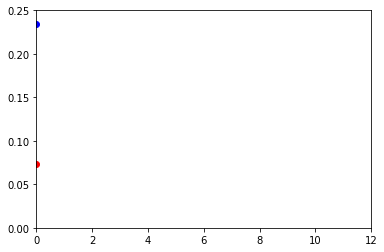

Epoch 2/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0837 - acc: 0.9749 - val_loss: 0.0546 - val_acc: 0.9832


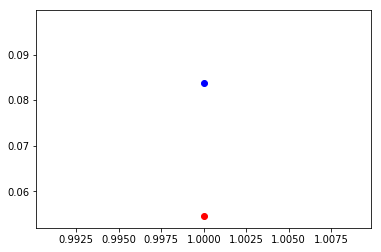

Epoch 3/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0638 - acc: 0.9809 - val_loss: 0.0471 - val_acc: 0.9855


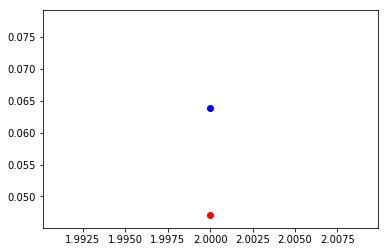

Epoch 4/12
49500/49500 [==============================] - 6s 122us/step - loss: 0.0533 - acc: 0.9845 - val_loss: 0.0501 - val_acc: 0.9852


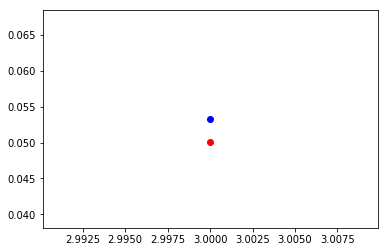

Epoch 5/12
49500/49500 [==============================] - 6s 122us/step - loss: 0.0481 - acc: 0.9861 - val_loss: 0.0432 - val_acc: 0.9876


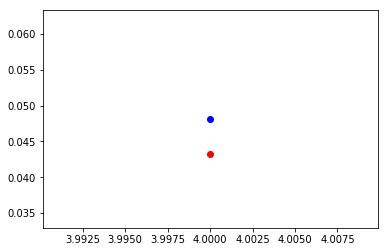

Epoch 6/12
49500/49500 [==============================] - 6s 122us/step - loss: 0.0417 - acc: 0.9881 - val_loss: 0.0456 - val_acc: 0.9875


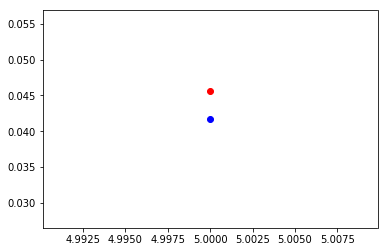

Epoch 7/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0387 - acc: 0.9880 - val_loss: 0.0432 - val_acc: 0.9874


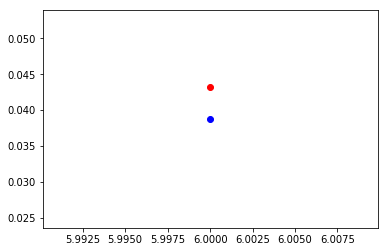

Epoch 8/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0403 - acc: 0.9883 - val_loss: 0.0482 - val_acc: 0.9859


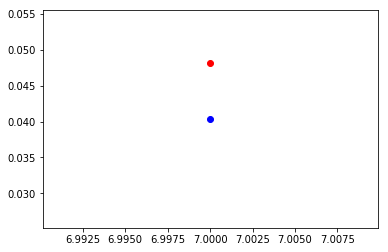

Epoch 9/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0406 - acc: 0.9879 - val_loss: 0.0421 - val_acc: 0.9877


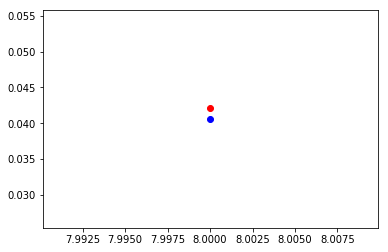

Epoch 10/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0395 - acc: 0.9884 - val_loss: 0.0458 - val_acc: 0.9882


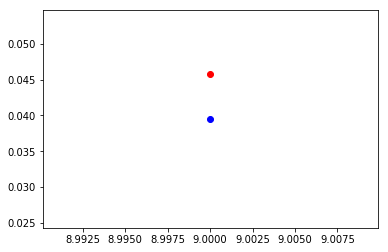

Epoch 11/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0434 - acc: 0.9878 - val_loss: 0.0451 - val_acc: 0.9896


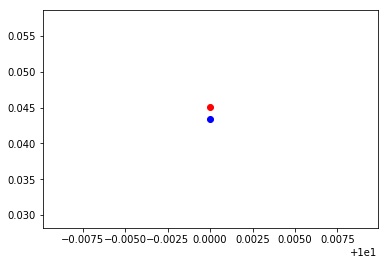

Epoch 12/12
49500/49500 [==============================] - 6s 123us/step - loss: 0.0433 - acc: 0.9878 - val_loss: 0.0434 - val_acc: 0.9886


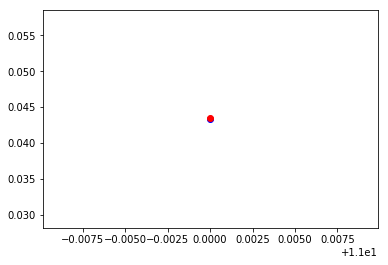

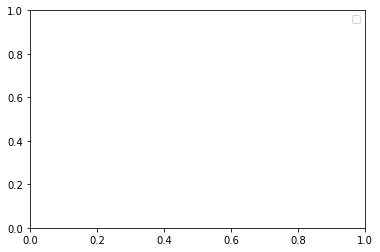

Test loss: 0.036914591207902414
Test accuracy: 0.9891


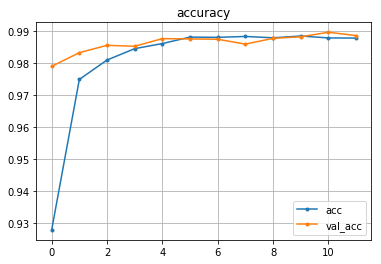

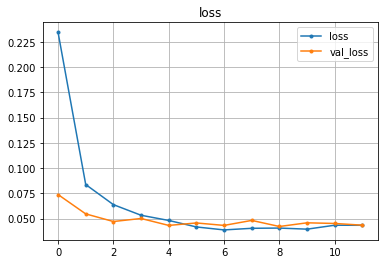

In [11]:
import easydict
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if __name__ == '__main__':
    args = easydict.EasyDict({
        "batch_size": 128,
        "epochs": 12,
        })

    args = vars(args)
    if args['epochs']:
        epochs = args['epochs']
    else:
        epochs = 12
    if args['batch_size']:
        batch_size = args['batch_size']
    else:
        batch_size = 128

    main(epochs, batch_size)

In [ ]:
#parser = argparse.ArgumentParser(description='Chainer')

# GPU ID
#parser.add_argument('--gpu', default=0, type=int,help='GPU ID (negative value indicates CPU)')
# 最大エポック数
#parser.add_argument('--max_epochs', default=10, help='max epochs', type=int)
# Batch size
#parser.add_argument('--batch_size', default=2, help='size of batch', type=int)
### 1人の被検者あたりに何個のデータを取るか
####parser.add_argument('--num_for_each', default=3, help='number for each patient', type=int)
# weight_decayパラメータ
#parser.add_argument('--weight_decay', default=0.0005, help='weight decay', type=float)
# 学習率パラメータ
#parser.add_argument('--lr', default=0.001, help='learning rate', type=float)
# fold number for K-fold
#parser.add_argument('--fold_number', default=2, help='fold number', type=int)


# コマンドラインの引数を解釈
#args = parser.parse_args()
# さらに，辞書形式に変換
#args = vars(args)
#GPU_ID = args['gpu']
#EPOCH_N = args['max_epochs']
#BATCH_SIZE = args['batch_size']
#NUM_FOR_EACH = args['num_for_each']
#WEIGHT_DECAY = args['weight_decay']
#LR = args['lr']
#FOLD_N= args['fold_number']


'''https://qiita.com/LittleWat/items/6e56857e1f97c842b261'''

In [ ]:
fpath = '/work/project/MEG_ChildrenBiomarker/code/data_table.csv'
Data_table = pd.read_csv(fpath)
Data_table

In [ ]:
def balanced_accuracy_score(y_true, y_pred):
    C = metrics.confusion_matrix(y_true,y_pred).astype(np.float32)
    # print 'balanced with {0:d} labels!'.format(C.shape[0])
    return np.mean(np.diag(C) / np.sum(C,axis=1))

In [ ]:
def load_img(args):
    I,j,Rand_id,index,NUM_FOR_EACH,Total_patient,Data_aq,Sample_num,File_path,result,disease_flag,label = args
    #print 'debug_j'
    #print j
    tmp_txt=''
    if (I + j >= Rand_id.shape[0]):
        # 最後のバッチの大きさが足りない場合
        pass
    else:
        Patient_N = index[Rand_id[I + j] / NUM_FOR_EACH]
        tmp_txt += 'patinet_n{0}\n'.format(Patient_N)
        res = Rand_id[I + j] % NUM_FOR_EACH
        loop_flag = 1
        for i in xrange(Total_patient):
            if (loop_flag):
                if (Data_aq[Patient_N, res] < np.sum(Sample_num[Patient_N, 0:i])):
                    s_n = int(Data_aq[Patient_N, res] - np.sum(Sample_num[Patient_N, 0:i - 1]))
                    fn = File_path[Patient_N, i - 1]
                    signal_data = h5py.File(fn, 'r')
                    meg_dat = signal_data['meg_dat'].value
                    tmp = meg_dat[s_n+10000:s_n + 10800, :]
                    tmp = tmp.transpose()
                    tmp = tmp[np.newaxis, np.newaxis, :, :]
                    tmp = tmp.astype(np.float32)
                    result[j, :, :, :] = tmp
                    loop_flag = 0
    tmp_res=[]
    tmp_res.append(result)
    tmp_res.append(tmp_txt)
    return tmp_res

In [ ]:
def load_label(args):
    I,j,Rand_id,index,NUM_FOR_EACH,Total_patient,Data_aq,Sample_num,File_path,result,disease_flag,label = args
    if (I + j >= Rand_id.shape[0]):
        # 最後のバッチの大きさが足りない場合
        return None
    else:
        Patient_N = index[Rand_id[I + j] / NUM_FOR_EACH]
        lab=disease_flag[Patient_N, 0]
        #print 'debug_label_j'
        #print j
        #print lab
        return lab

In [ ]:
def Load_Batch(I, NUM_FOR_EACH,Rand_id, index,Data_aq,Batch_size, File_path, Sample_num, Total_patient):
    result=np.zeros((Batch_size,1,160,800),dtype=np.float32) #800sample,160chを仮定
    label=[]
    p=Pool(10)
    tmp_res= p.map(load_img,[ (I,j,Rand_id,index,NUM_FOR_EACH,Total_patient,Data_aq,Sample_num,File_path,result,disease_flag,label) for j in xrange(Batch_size) ])
    tmp_lab = p.map(load_label, [(I, j, Rand_id, index, NUM_FOR_EACH, Total_patient, Data_aq, Sample_num, File_path, result, disease_flag, label) for j in xrange(Batch_size)])
    #print tmp_res[0].shape
    #print tmp_lab
    p.close()
    for k in xrange(len(tmp_res)):
        #print tmp[k]
        result+=(tmp_res[k])[0]

    #print result
    #print len(label)
    label=np.array(tmp_lab)
    #print label
    #print type(label[0])
    #print result.shape

    #print result.shape
    #channel毎のscale

    for a in range(result.shape[0]):
        for b in range(result.shape[2]):
            result[a, 0, b, :] = preprocessing.scale(result[a, 0, b, :] )
            #print 'debug'
            #print result[a, 0, b, :].mean(axis=0)
            #print result[a, 0, b, :].std(axis=0)

    result = result[0:label.shape[0], :, :, :]

    #print 'debug'
    #save_debug = os.path.join(save_dir, 'debug.npz')
    #np.savez(save_debug, result=result, label=label)
    #print result.shape
    return result,label

In [ ]:
def Load_Test_Batch(Index_num,Test_batch_size, File_path, Disease_flag):
    result=np.zeros((Test_batch_size,1,160,800),dtype=np.float32)
    label = np.ones((Test_batch_size),dtype=np.int32)*Disease_flag[Index_num,0]

    fn = File_path[Index_num, 0]
    signal_data = h5py.File(fn, 'r')
    meg_dat = signal_data['meg_dat'].value

    for j in xrange(Test_batch_size):
        tmp = meg_dat[j*800+10000:(j+1)*800+10000, :]
        tmp = tmp.transpose()
        tmp = tmp[np.newaxis, np.newaxis, :, :]
        tmp = tmp.astype(np.float32)
        result[j, :, :, :] = tmp

    #channel毎のscale
    for a in range(result.shape[0]):
        for b in range(result.shape[2]):
            result[a, 0, b, :] = preprocessing.scale(result[a, 0, b, :] )

    return result,label

In [ ]:
def forward(x_data, y_data, model_use, train=True ):
    x, t = Variable(x_data), Variable(y_data)
    test = not train

    h = F.relu(model_use.norm1(model_use.conv1(x), test=test))
    h = F.relu(model_use.norm2(model_use.conv2(h), test=test))
    h = F.max_pooling_2d(h, (1, 10), stride=(1, 10)) # stride=(1, 160) -> stride=(1, 20)
    h = F.reshape(h, (h.data.shape[0], h.data.shape[2], h.data.shape[1], h.data.shape[3]))

    h = F.relu(model_use.norm4(model_use.conv4(h), test=test))
    h = F.max_pooling_2d(h, 3, stride=3)
    h = F.relu(model_use.norm5(model_use.conv5(h), test=test))
    h = F.max_pooling_2d(h, (1, 2), stride=(1, 2))

    h = F.relu(model_use.norm6(model_use.fc6(h), test=test))
    h = F.dropout(h, train=train)
    h = F.relu(model_use.norm7(model_use.fc7(h), test=test))
    h = F.dropout(h, train=train)
    y = model_use.fc8(h)

    if train:
        return F.softmax_cross_entropy(y, t), F.accuracy(y, t), F.softmax(y)
    else:
        return F.softmax(y)

In [ ]:
# 計算コンディションを出力する
# まずは，プログラムの引数
log_txt=''
log_txt += '-----------Arguments-----------\n'
for key, value in args.iteritems():
    log_txt += key + ': ' +  value.__str__() + '\n'
log_txt += '\n'

#Cross validation K-fold
skf = StratifiedKFold(disease_flag[:,0], n_folds=FOLD_N, shuffle=True)
# Currnet fold number
c_f=0

#データ数
N_data=136*100
#*2をしているのは、ラベルに用いていない2をはじめに配列に入れておくことで、後で、除去できるようにするため。
#train dataにおいて、各fold,各epochでのラベルの予測を保存する配列
train_labels_pred=np.ones((FOLD_N,N_data,EPOCH_N))*2
#train dataにおいて、各fold,各epochでのラベルの真値を保存する配列
train_labels_true=np.ones((FOLD_N,N_data,EPOCH_N))*2